In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [3]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers = no_of_workers)

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [8]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [12]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

# initialize weights if the model is not found in the paths
if os.path.exists("saved_models/generator.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found
Discriminator Found


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

In [19]:
for epoch in range(10):
    for i, batch in tqdm(enumerate(pair_image_dataloader)):
        real_A = batch['A'].unsqueeze(0) # old image
        real_B = batch['B'].unsqueeze(0) # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        if i % 100 == 0 and i:
            print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
            print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
            
        # train with only 5000 images
        if i % 500 ==  0 and i > 0:
            break

102it [00:08, 12.85it/s]

Generator Error: 5.783392906188965, epoch: 0, itr: 100
Discriminator Error: 0.0050972262397408485, epoch: 0, itr: 100


202it [00:15, 12.79it/s]

Generator Error: 7.5512237548828125, epoch: 0, itr: 200
Discriminator Error: 0.00810285471379757, epoch: 0, itr: 200


302it [00:23, 12.68it/s]

Generator Error: 5.825913906097412, epoch: 0, itr: 300
Discriminator Error: 0.0040184431709349155, epoch: 0, itr: 300


402it [00:31, 12.66it/s]

Generator Error: 3.745011329650879, epoch: 0, itr: 400
Discriminator Error: 0.014158882200717926, epoch: 0, itr: 400


500it [00:39, 12.73it/s]
2it [00:00, 12.74it/s]

Generator Error: 4.503420352935791, epoch: 0, itr: 500
Discriminator Error: 0.006660321727395058, epoch: 0, itr: 500


102it [00:08, 12.64it/s]

Generator Error: 5.601968765258789, epoch: 1, itr: 100
Discriminator Error: 0.0077840168960392475, epoch: 1, itr: 100


202it [00:15, 12.64it/s]

Generator Error: 7.487140655517578, epoch: 1, itr: 200
Discriminator Error: 0.006197412498295307, epoch: 1, itr: 200


302it [00:23, 12.27it/s]

Generator Error: 6.2593889236450195, epoch: 1, itr: 300
Discriminator Error: 0.006505661644041538, epoch: 1, itr: 300


402it [00:31, 12.39it/s]

Generator Error: 3.8490653038024902, epoch: 1, itr: 400
Discriminator Error: 0.04471653327345848, epoch: 1, itr: 400


500it [00:39, 12.57it/s]
2it [00:00, 12.99it/s]

Generator Error: 4.987227439880371, epoch: 1, itr: 500
Discriminator Error: 0.004687851294875145, epoch: 1, itr: 500


102it [00:08, 12.55it/s]

Generator Error: 5.234807968139648, epoch: 2, itr: 100
Discriminator Error: 0.017136171460151672, epoch: 2, itr: 100


202it [00:16, 12.56it/s]

Generator Error: 7.08931303024292, epoch: 2, itr: 200
Discriminator Error: 0.0039708674885332584, epoch: 2, itr: 200


302it [00:24, 12.48it/s]

Generator Error: 6.752815246582031, epoch: 2, itr: 300
Discriminator Error: 0.004348319955170155, epoch: 2, itr: 300


402it [00:32, 12.41it/s]

Generator Error: 3.4763946533203125, epoch: 2, itr: 400
Discriminator Error: 0.1837456375360489, epoch: 2, itr: 400


500it [00:39, 12.52it/s]
2it [00:00, 12.66it/s]

Generator Error: 5.407909870147705, epoch: 2, itr: 500
Discriminator Error: 0.0026981632690876722, epoch: 2, itr: 500


102it [00:08, 12.58it/s]

Generator Error: 5.210819721221924, epoch: 3, itr: 100
Discriminator Error: 0.013318430632352829, epoch: 3, itr: 100


202it [00:16, 12.40it/s]

Generator Error: 7.500528335571289, epoch: 3, itr: 200
Discriminator Error: 0.009394556283950806, epoch: 3, itr: 200


302it [00:24, 12.48it/s]

Generator Error: 6.045241355895996, epoch: 3, itr: 300
Discriminator Error: 0.004100219812244177, epoch: 3, itr: 300


402it [00:31, 12.45it/s]

Generator Error: 4.771693229675293, epoch: 3, itr: 400
Discriminator Error: 0.02201186865568161, epoch: 3, itr: 400


500it [00:39, 12.54it/s]
2it [00:00, 12.50it/s]

Generator Error: 4.953871250152588, epoch: 3, itr: 500
Discriminator Error: 0.002241019159555435, epoch: 3, itr: 500


102it [00:08, 12.61it/s]

Generator Error: 6.230212211608887, epoch: 4, itr: 100
Discriminator Error: 0.0034565338864922523, epoch: 4, itr: 100


202it [00:16, 12.61it/s]

Generator Error: 7.1201653480529785, epoch: 4, itr: 200
Discriminator Error: 0.0033266970422118902, epoch: 4, itr: 200


302it [00:23, 12.58it/s]

Generator Error: 6.028860569000244, epoch: 4, itr: 300
Discriminator Error: 0.008260739967226982, epoch: 4, itr: 300


402it [00:31, 12.49it/s]

Generator Error: 3.483795166015625, epoch: 4, itr: 400
Discriminator Error: 0.22849580645561218, epoch: 4, itr: 400


500it [00:39, 12.54it/s]
2it [00:00, 12.82it/s]

Generator Error: 4.369686126708984, epoch: 4, itr: 500
Discriminator Error: 0.007901199162006378, epoch: 4, itr: 500


102it [00:08, 12.43it/s]

Generator Error: 5.2546162605285645, epoch: 5, itr: 100
Discriminator Error: 0.006745009683072567, epoch: 5, itr: 100


202it [00:16, 12.33it/s]

Generator Error: 7.345724105834961, epoch: 5, itr: 200
Discriminator Error: 0.011909577995538712, epoch: 5, itr: 200


302it [00:24, 12.41it/s]

Generator Error: 5.940702438354492, epoch: 5, itr: 300
Discriminator Error: 0.004113268107175827, epoch: 5, itr: 300


402it [00:32, 12.42it/s]

Generator Error: 3.914461851119995, epoch: 5, itr: 400
Discriminator Error: 0.017470479011535645, epoch: 5, itr: 400


500it [00:40, 12.44it/s]
2it [00:00, 12.66it/s]

Generator Error: 4.906898498535156, epoch: 5, itr: 500
Discriminator Error: 0.004375426098704338, epoch: 5, itr: 500


102it [00:08, 12.45it/s]

Generator Error: 5.410348415374756, epoch: 6, itr: 100
Discriminator Error: 0.0057600741274654865, epoch: 6, itr: 100


202it [00:16, 12.38it/s]

Generator Error: 7.112176895141602, epoch: 6, itr: 200
Discriminator Error: 0.004559697583317757, epoch: 6, itr: 200


302it [00:24, 12.36it/s]

Generator Error: 5.733858585357666, epoch: 6, itr: 300
Discriminator Error: 0.014136845245957375, epoch: 6, itr: 300


402it [00:32, 12.36it/s]

Generator Error: 3.956289529800415, epoch: 6, itr: 400
Discriminator Error: 0.029227636754512787, epoch: 6, itr: 400


500it [00:40, 12.43it/s]
2it [00:00, 12.74it/s]

Generator Error: 4.6831207275390625, epoch: 6, itr: 500
Discriminator Error: 0.007902268320322037, epoch: 6, itr: 500


102it [00:08, 12.36it/s]

Generator Error: 5.919722557067871, epoch: 7, itr: 100
Discriminator Error: 0.011623790487647057, epoch: 7, itr: 100


202it [00:16, 12.26it/s]

Generator Error: 6.926002025604248, epoch: 7, itr: 200
Discriminator Error: 0.0038528828881680965, epoch: 7, itr: 200


302it [00:24, 12.17it/s]

Generator Error: 5.788242340087891, epoch: 7, itr: 300
Discriminator Error: 0.0040068840608000755, epoch: 7, itr: 300


402it [00:32, 12.35it/s]

Generator Error: 3.5037636756896973, epoch: 7, itr: 400
Discriminator Error: 0.009859008714556694, epoch: 7, itr: 400


500it [00:40, 12.35it/s]
2it [00:00, 12.35it/s]

Generator Error: 5.253652572631836, epoch: 7, itr: 500
Discriminator Error: 0.00783957913517952, epoch: 7, itr: 500


102it [00:08, 12.34it/s]

Generator Error: 5.289395332336426, epoch: 8, itr: 100
Discriminator Error: 0.0103444904088974, epoch: 8, itr: 100


202it [00:16, 12.16it/s]

Generator Error: 7.115246772766113, epoch: 8, itr: 200
Discriminator Error: 0.01033796463161707, epoch: 8, itr: 200


302it [00:24, 12.37it/s]

Generator Error: 6.149521827697754, epoch: 8, itr: 300
Discriminator Error: 0.0075444248504936695, epoch: 8, itr: 300


402it [00:32, 12.35it/s]

Generator Error: 3.6781983375549316, epoch: 8, itr: 400
Discriminator Error: 0.041795410215854645, epoch: 8, itr: 400


500it [00:40, 12.35it/s]
2it [00:00, 12.82it/s]

Generator Error: 4.515974521636963, epoch: 8, itr: 500
Discriminator Error: 0.0028836349956691265, epoch: 8, itr: 500


102it [00:08, 12.38it/s]

Generator Error: 5.303391456604004, epoch: 9, itr: 100
Discriminator Error: 0.03651905432343483, epoch: 9, itr: 100


202it [00:16, 12.44it/s]

Generator Error: 7.714160919189453, epoch: 9, itr: 200
Discriminator Error: 0.003990299999713898, epoch: 9, itr: 200


302it [00:24, 12.26it/s]

Generator Error: 5.819455623626709, epoch: 9, itr: 300
Discriminator Error: 0.006640174891799688, epoch: 9, itr: 300


402it [00:32, 12.20it/s]

Generator Error: 3.344813823699951, epoch: 9, itr: 400
Discriminator Error: 0.15095660090446472, epoch: 9, itr: 400


500it [00:40, 12.44it/s]

Generator Error: 4.651077747344971, epoch: 9, itr: 500
Discriminator Error: 0.016453687101602554, epoch: 9, itr: 500


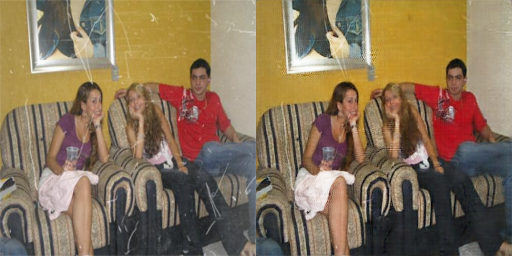

In [27]:
test_image_index = 2500

output_image = image_manipulation.np_to_pil(
    generator(pair_image_dataloader[test_image_index]['A'].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    pair_image_dataloader[test_image_index]['A'].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image

In [28]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True